In [1]:
%load_ext autoreload
%autoreload 2

from model import *
from image import *
from utils import *
from generate import *

# setup stylenet
params = StylenetArgs()
params.gpu = '0'
params.backend = 'cudnn'
params.model_file = 'models/vgg19-d01eb7cb.pth'

dtype, multidevice, backward_device = setup_gpu(params)
stylenet = StyleNet(params, dtype, multidevice, backward_device, verbose=False)


Model setup successfully with parameters:
gpu: 0, optimizer: lbfgs, learning_rate: 1.00, lbfgs_num_correction: 100, pooling: max, model_file: models/vgg19-d01eb7cb.pth, False, backend: cudnn, False, content_layers: relu4_2, style_layers: relu1_1,relu2_1,relu3_1,relu4_1,relu5_1, hist_layers: relu2_1,relu3_1,relu4_1,relu5_1, multidevice_strategy: 4,7,29


## Simple example


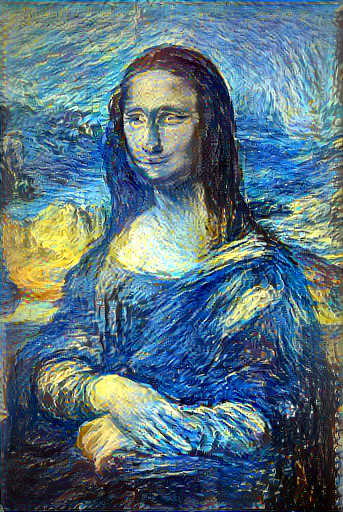

In [2]:
config = {
    'content_image': 'images/inputs/monalisa.jpg',
    'style_image': 'images/inputs/starry_night.jpg'
}

img = style_transfer(stylenet, config)
display(img)

## More customized

Additional parameters to customize: 
* `size`: size of canvas (default 512). Either as tuple `(h, w)` or maximum dimension.
* `style_scale`: At what scale resolution to extract style features fr om style images (deault 1.0)
* `input_image`: Start canvas from another image, rather than from random.
* `num_iterations`: How many steps for the optimization (default 1000)
* `original_colors`: Once done, transfer color distribution to that of the content image.

Note that all images, `content_image`, `style_images`, and `input_image` can all be either actual images or paths to saved images on disk.

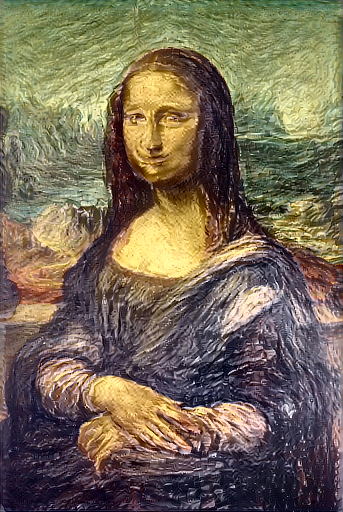

In [3]:

config = {
    'size': 512, #(1024, 768), 
    'content_image': 'images/inputs/monalisa.jpg',
    'style_images': 'images/inputs/starry_night.jpg',
    'style_scale': 1.0,
    'num_iterations': 1000,
    'original_colors': True
}

img = style_transfer(stylenet, config)
display(img)

## Multi-resolution

Additional parameters to customize: 
* `num_octaves`: size of canvas (default 512). Either as tuple `(w, h)` or maximum dimension.
* `octave_scale`: At what scale resolution to extract style features fr om style images (deault 1.0)
* `num_iterations` and `style_scale` can be set as 1 element, i.e. same for each resolution, or as lists


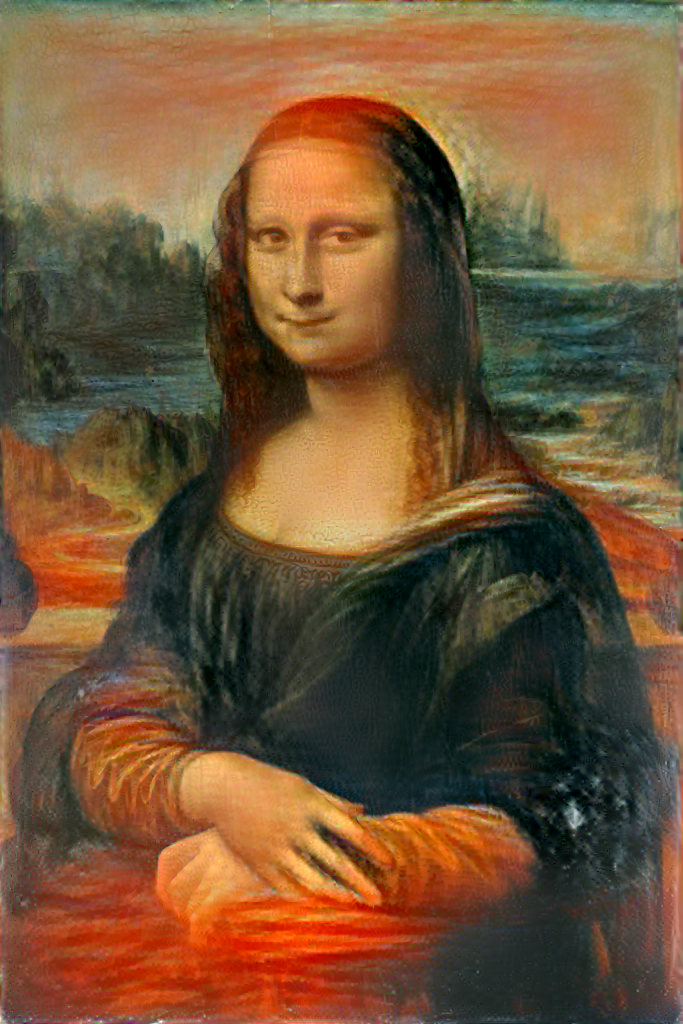

In [4]:

config = {
    'size': (683, 1024),
    'content_image': 'images/inputs/monalisa.jpg',
    'style_images': 'images/inputs/the_scream.jpg',
    'num_iterations': [1000, 750, 500],
    'num_octaves': 3,
    'octave_ratio': 2.0
}

img = style_transfer(stylenet, config)
display(img)

The output of an image can be saved.

In [5]:
save(img, 'my_example3.png')

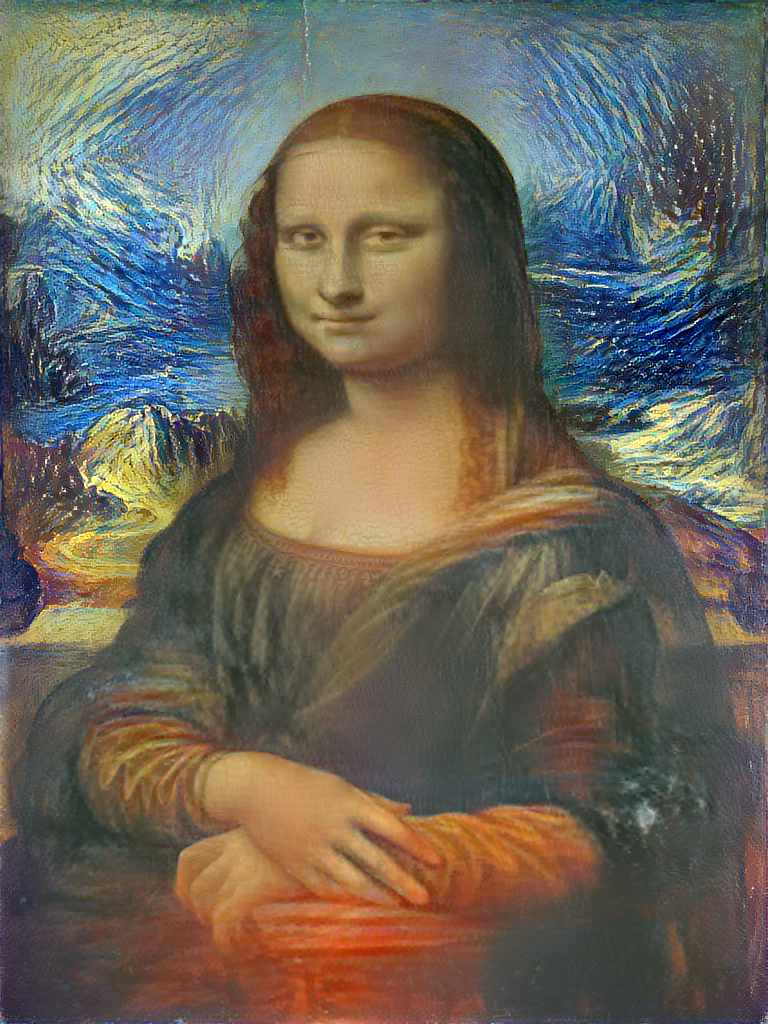

In [6]:

config = {
    'size': (768, 1024), 
    'content_image': 'images/inputs/monalisa.jpg',
    'style_images': ['images/inputs/the_scream.jpg',
                     'images/inputs/starry_night.jpg'],
    'content_masks': ['images/masks/monalisa1b.png',
                      'images/masks/monalisa1a.png'],
    'style_scale': 1.0,
    'num_iterations': [800, 500, 250],
    'num_octaves': 3,
    'octave_ratio': 1.8,
    'original_colors': False
}


img = style_transfer(stylenet, config)
display(img)

save(img, 'myimg2.png')


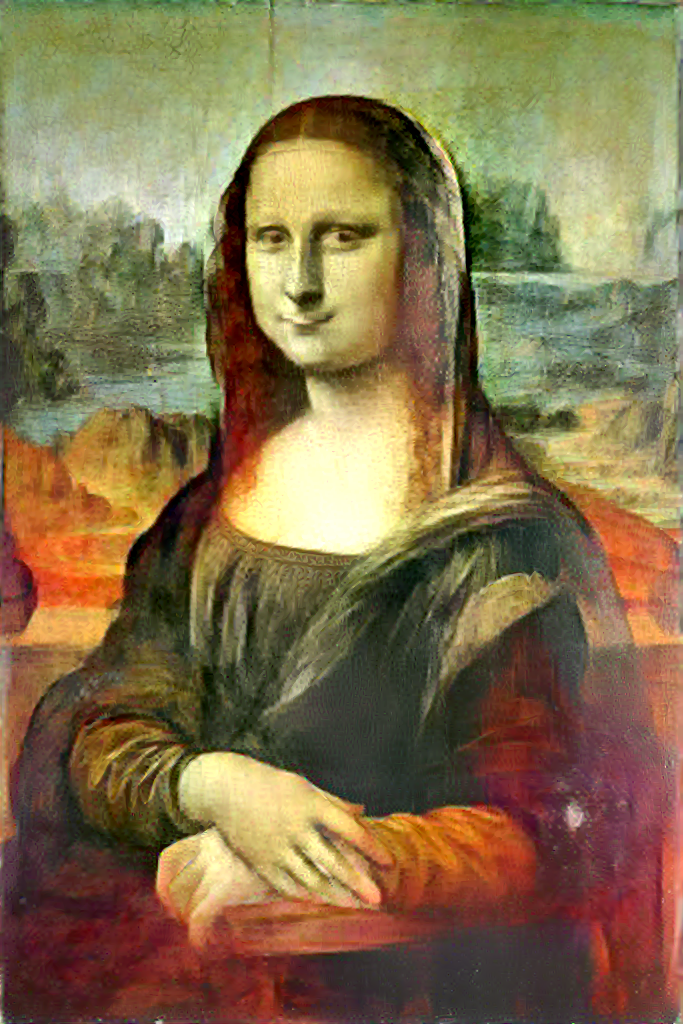

In [7]:

config = {
    'size': (683, 1024),
    'content_image': 'images/inputs/monalisa.jpg',
    'style_images': 'https://www.artyfactory.com/art_appreciation/art_movements/art-movements/cubism/picasso_cubism.jpg',
    'num_iterations': [1000, 750, 500],
    'num_octaves': 3,
    'octave_ratio': 2.0
}

img = style_transfer(stylenet, config)
display(img)

## Doing everything manually

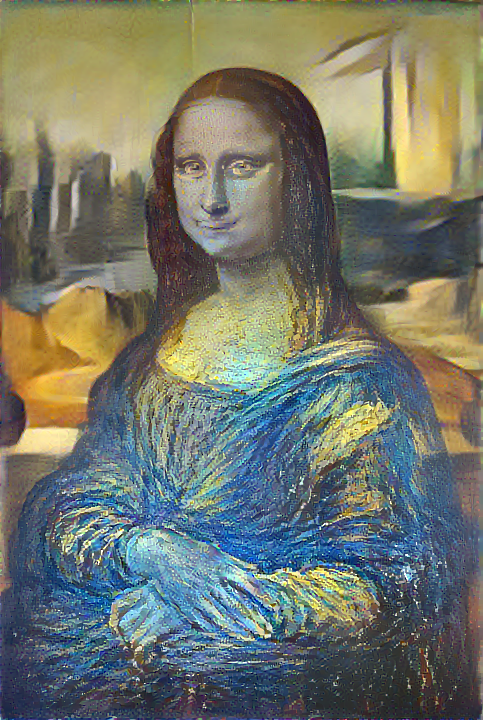

In [8]:
# set stylenet hyper-parameters
#stylenet.set_content_weight(5e2)
#stylenet.set_style_weight(1e2)
#stylenet.set_hist_weight(1e3)
#stylenet.set_style_statistic('gram')
#stylenet.set_tv_weight(1e-2)

# set stylenet style layers individually
#stylenet.set_style_layer(0, 'covariance', 5e3)
#stylenet.set_style_layer(1, 'gram', 1e2)
#stylenet.set_style_layer(2, 'gram', 1e2)
#stylenet.set_style_layer(3, 'gram', 1e2)
#stylenet.set_style_layer(4, 'gram', 1e2)
#stylenet.set_hist_layer(0, 5e1)
#stylenet.set_hist_layer(1, 5e1)
#stylenet.set_hist_layer(2, 5e1)
#stylenet.set_hist_layer(3, 5e1)


# parameters
image_size = 720
style_scale = 1.0

# load content image
content_path = 'images/inputs/monalisa.jpg'
content_image = load_image(content_path, image_size)

# load style images
style_paths = ['images/inputs/starry_night.jpg',
               'images/inputs/cubist.jpg']
 
style_size = int(image_size * style_scale)
style_images = [load_image(path, style_size) for path in style_paths]

# load content masks for each style image
content_mask_paths = ['images/masks/monalisa1b.png',
                      'images/masks/monalisa1a.png']
content_masks = [load_image(mask, image_size) 
                 for mask in content_mask_paths]

# capture the style and content images
stylenet.capture(content_image, style_images, None, content_masks)

# initialize input image with a random image
# or load it from another image (e.g. content)
input_img = random_tensor_like(content_image)
#input_img = preprocess(load_image('../images/inputs/the_scream.jpg', image_size)) # make sure matches size of content
#input_img = preprocess(load_image(content_path, image_size))

# optimizer
img = optimize(stylenet, 
               input_img, 
               num_iterations=1000,  
               update_iter=100, 
               display_preview=True,
               save_preview=False,
               save_preview_path=None)

img = deprocess(img)

# change back to original colors of content image if you want
#img = original_colors(content_image, img)

save(img, "output_single.png")
display(img)